In [1]:
#importing the necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.cm as cm
import warnings
import warnings



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Project: Pairs Selection 

### Milestone 2
Team Members: Kareema Batool, Nikhil Nayak, Nishtha Sardana, Saket Joshi

## Introduction

Pairs trading is a market-neutral strategy where we use statistical techniques to identify two stocks that are historically highly correlated with each other. When there is a deviation in the price relationship of these stocks, we expect this to be mean reverting and buy the underperforming stock and simultaneously sell the outperforming one. If our mean-reversion assumption is valid then prices should converge to long term average and trade should benefit. However, if the price divergence is not temporary and it is due to structural reasons then there is a high risk of losing the money. 

## Problem Statement

## Data

We have taken NIFTY-100 data for the past 3 years on a day level basis for our analysis. However, we have considered the companies who have complete data for our selected tenure and escaped any that were listed. For each of these companies, we have taken the 'closing value' for our further analysis. However, we have eliminated businesses that lack data for the chosen tenure, leaving only the top 88 stocks. For these 88 equities, we use the closing price on a daily basis.

In [3]:
# assign path
path, dirs, files = next(os.walk("project/nifty_2018_2022_day 2/"))
file_count = len(files)
# create empty list
dataframes_list = []


df = None
# append datasets to the list
for i in range(file_count):
    temp_df = pd.read_csv("project/nifty_2018_2022_day 2/"+files[i], compression='gzip')
    df = pd.concat([df, temp_df[['close']].rename(columns = {'close':files[i][:-4]})], axis=1)
     

In [4]:
#exploring our cleaned data
print('A quick view of our cleaned dataset for 5 stocks')
df.iloc[:5, :5]

A quick view of our cleaned dataset for 5 stocks


,BHARTIARTL,TATASTEEL,BOSCHLTD,TITAN,INDUSTOWER
0,518.15,72.20,19791.90,852.45,369.95
1,507.05,72.95,19721.75,845.15,378.80
2,508.65,73.50,19692.95,856.30,378.65
3,513.35,76.00,19652.65,892.90,379.05
4,530.05,77.05,19693.15,909.70,372.60


## Exploring the correlation and cointegration between the pair of stocks

As a first step, we start by exploring the highly correlated pairs in our dataset of 88 companies. 

We have leveraged the Pearson Correlation Coefficient to gain a general understanding of the relationship between these companies before trying to explore and locate cointegrated stocks. 

Pearson correlation coefficient varies between +1 to -1 and is a linear measure of the relationship between two variables. The value +1 indicates a strong positive correlation, zero indicates no relationship, and -1 indicates a strong negative relationship. 

We can observe from the below generated heatmap that there are multiple pairs with a strong positive correlation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


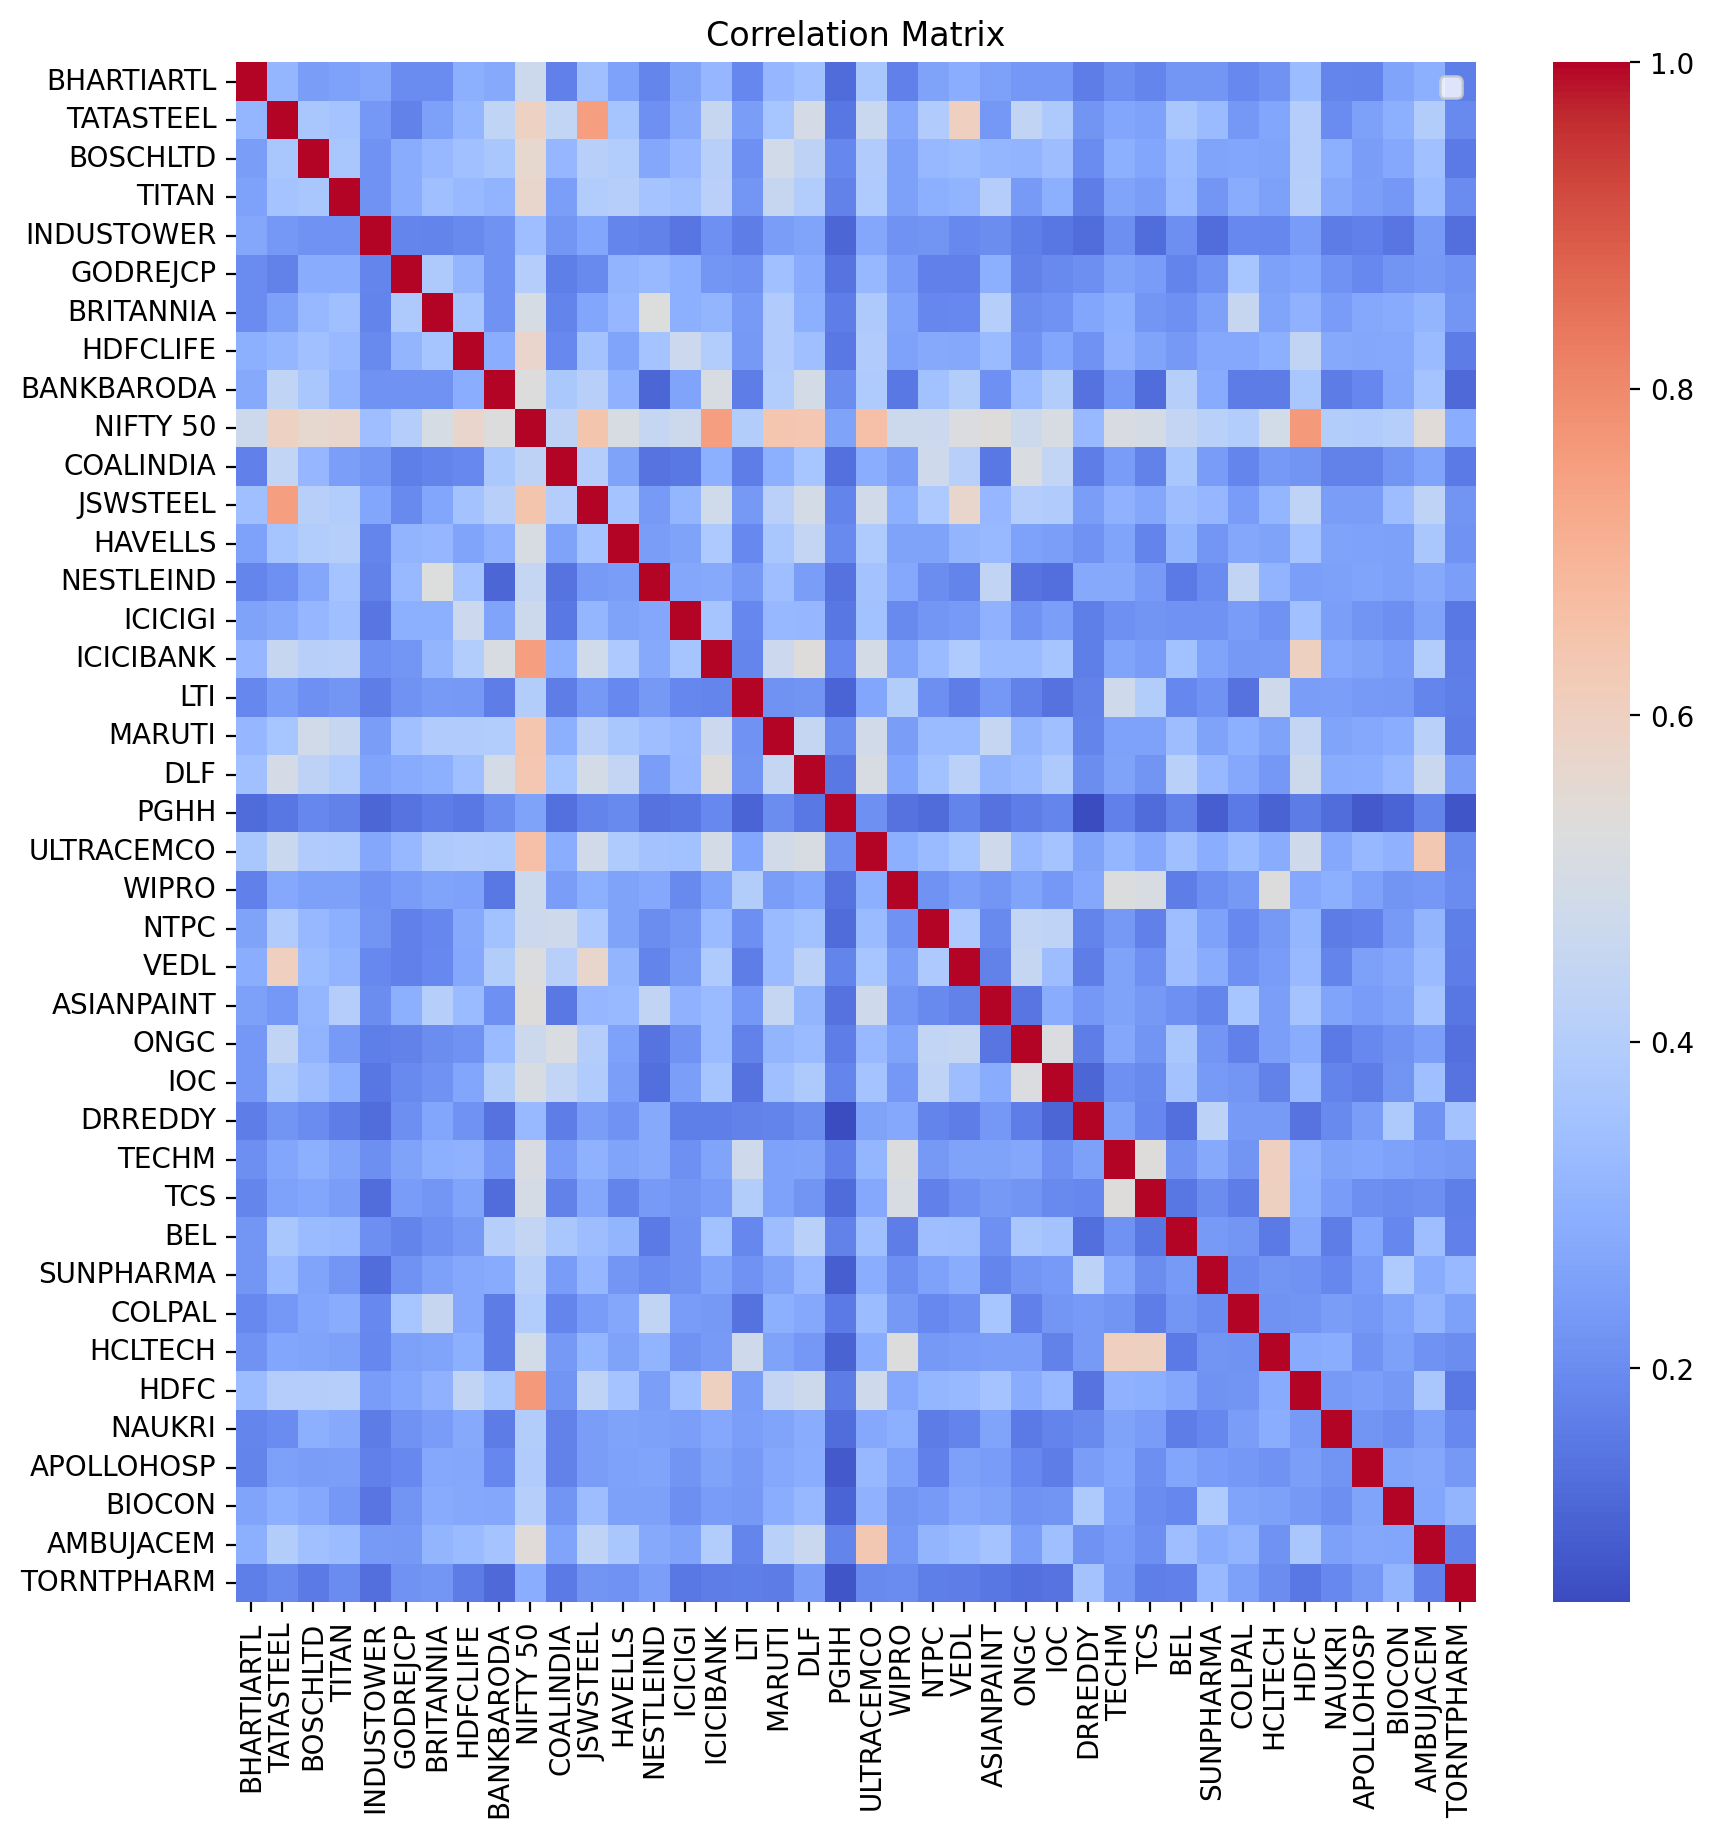

In [38]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,10))
# plt.xticks(fontsize=45)
# plt.yticks(fontsize=45)
# plt.legend(fontsize=90)
plt.xticks()
plt.yticks()
plt.legend()
sns.heatmap(df[df.columns[:40]].pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=False) #spearman
ax.set_title('Correlation Matrix')
warnings.simplefilter('ignore')
# plt.savefig("correlation.png")

In [15]:
print("10 pairs of stocks with the highest correlation values ")
df.corr().unstack().sort_values(ascending=False).drop_duplicates()[:10]

10 pairs of stocks with the highest correlation values 


BHARTIARTL  BHARTIARTL    1.000000
INFY        HCLTECH       0.983572
            TCS           0.982431
TCS         HCLTECH       0.978182
SRF         TITAN         0.977750
TATACONSUM  PIIND         0.977447
ASIANPAINT  PIDILITIND    0.977250
ADANIENT    ADANITRANS    0.977137
ICICIBANK   SIEMENS       0.975476
LTI         INFY          0.974692
dtype: float64

In [16]:
print("10 pairs of stocks with the lowest correlation values ")
df.corr().unstack().sort_values(ascending=True).drop_duplicates()[:10]

10 pairs of stocks with the lowest correlation values 


COALINDIA   ICICIGI      -0.811461
DRREDDY     COALINDIA    -0.799432
IOC         NESTLEIND    -0.778554
DRREDDY     INDUSINDBK   -0.768317
NESTLEIND   INDUSINDBK   -0.764811
MUTHOOTFIN  COALINDIA    -0.764371
DRREDDY     IOC          -0.762120
NESTLEIND   COALINDIA    -0.756310
BERGEPAINT  COALINDIA    -0.755774
IOC         HINDUNILVR   -0.734242
dtype: float64

In [8]:
!python3 -m pip install tqdm

In [21]:
import tqdm

# function to find cointegrated pairs
def find_cointegrated_pairs_(data, maxrows=500):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm.tqdm(range(n)):
        for j in range(i+1, n):
            result = coint(data[keys[i]].iloc[:maxrows], data[keys[j]].iloc[:maxrows])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [18]:
keys = df.keys()
coint(df[keys[0]], df[keys[3]])[1]

0.09843836792276944

In [34]:
pvalues[:40,:40]

array([[1.        , 0.44685333, 0.17846299, ..., 0.20350928, 0.52235968,
        0.38556094],
       [1.        , 1.        , 0.16924917, ..., 0.07585262, 0.11677546,
        0.37120054],
       [1.        , 1.        , 1.        , ..., 0.01546405, 0.47957657,
        0.70071416],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 0.3628737 ,
        0.44124255],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.05125976],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

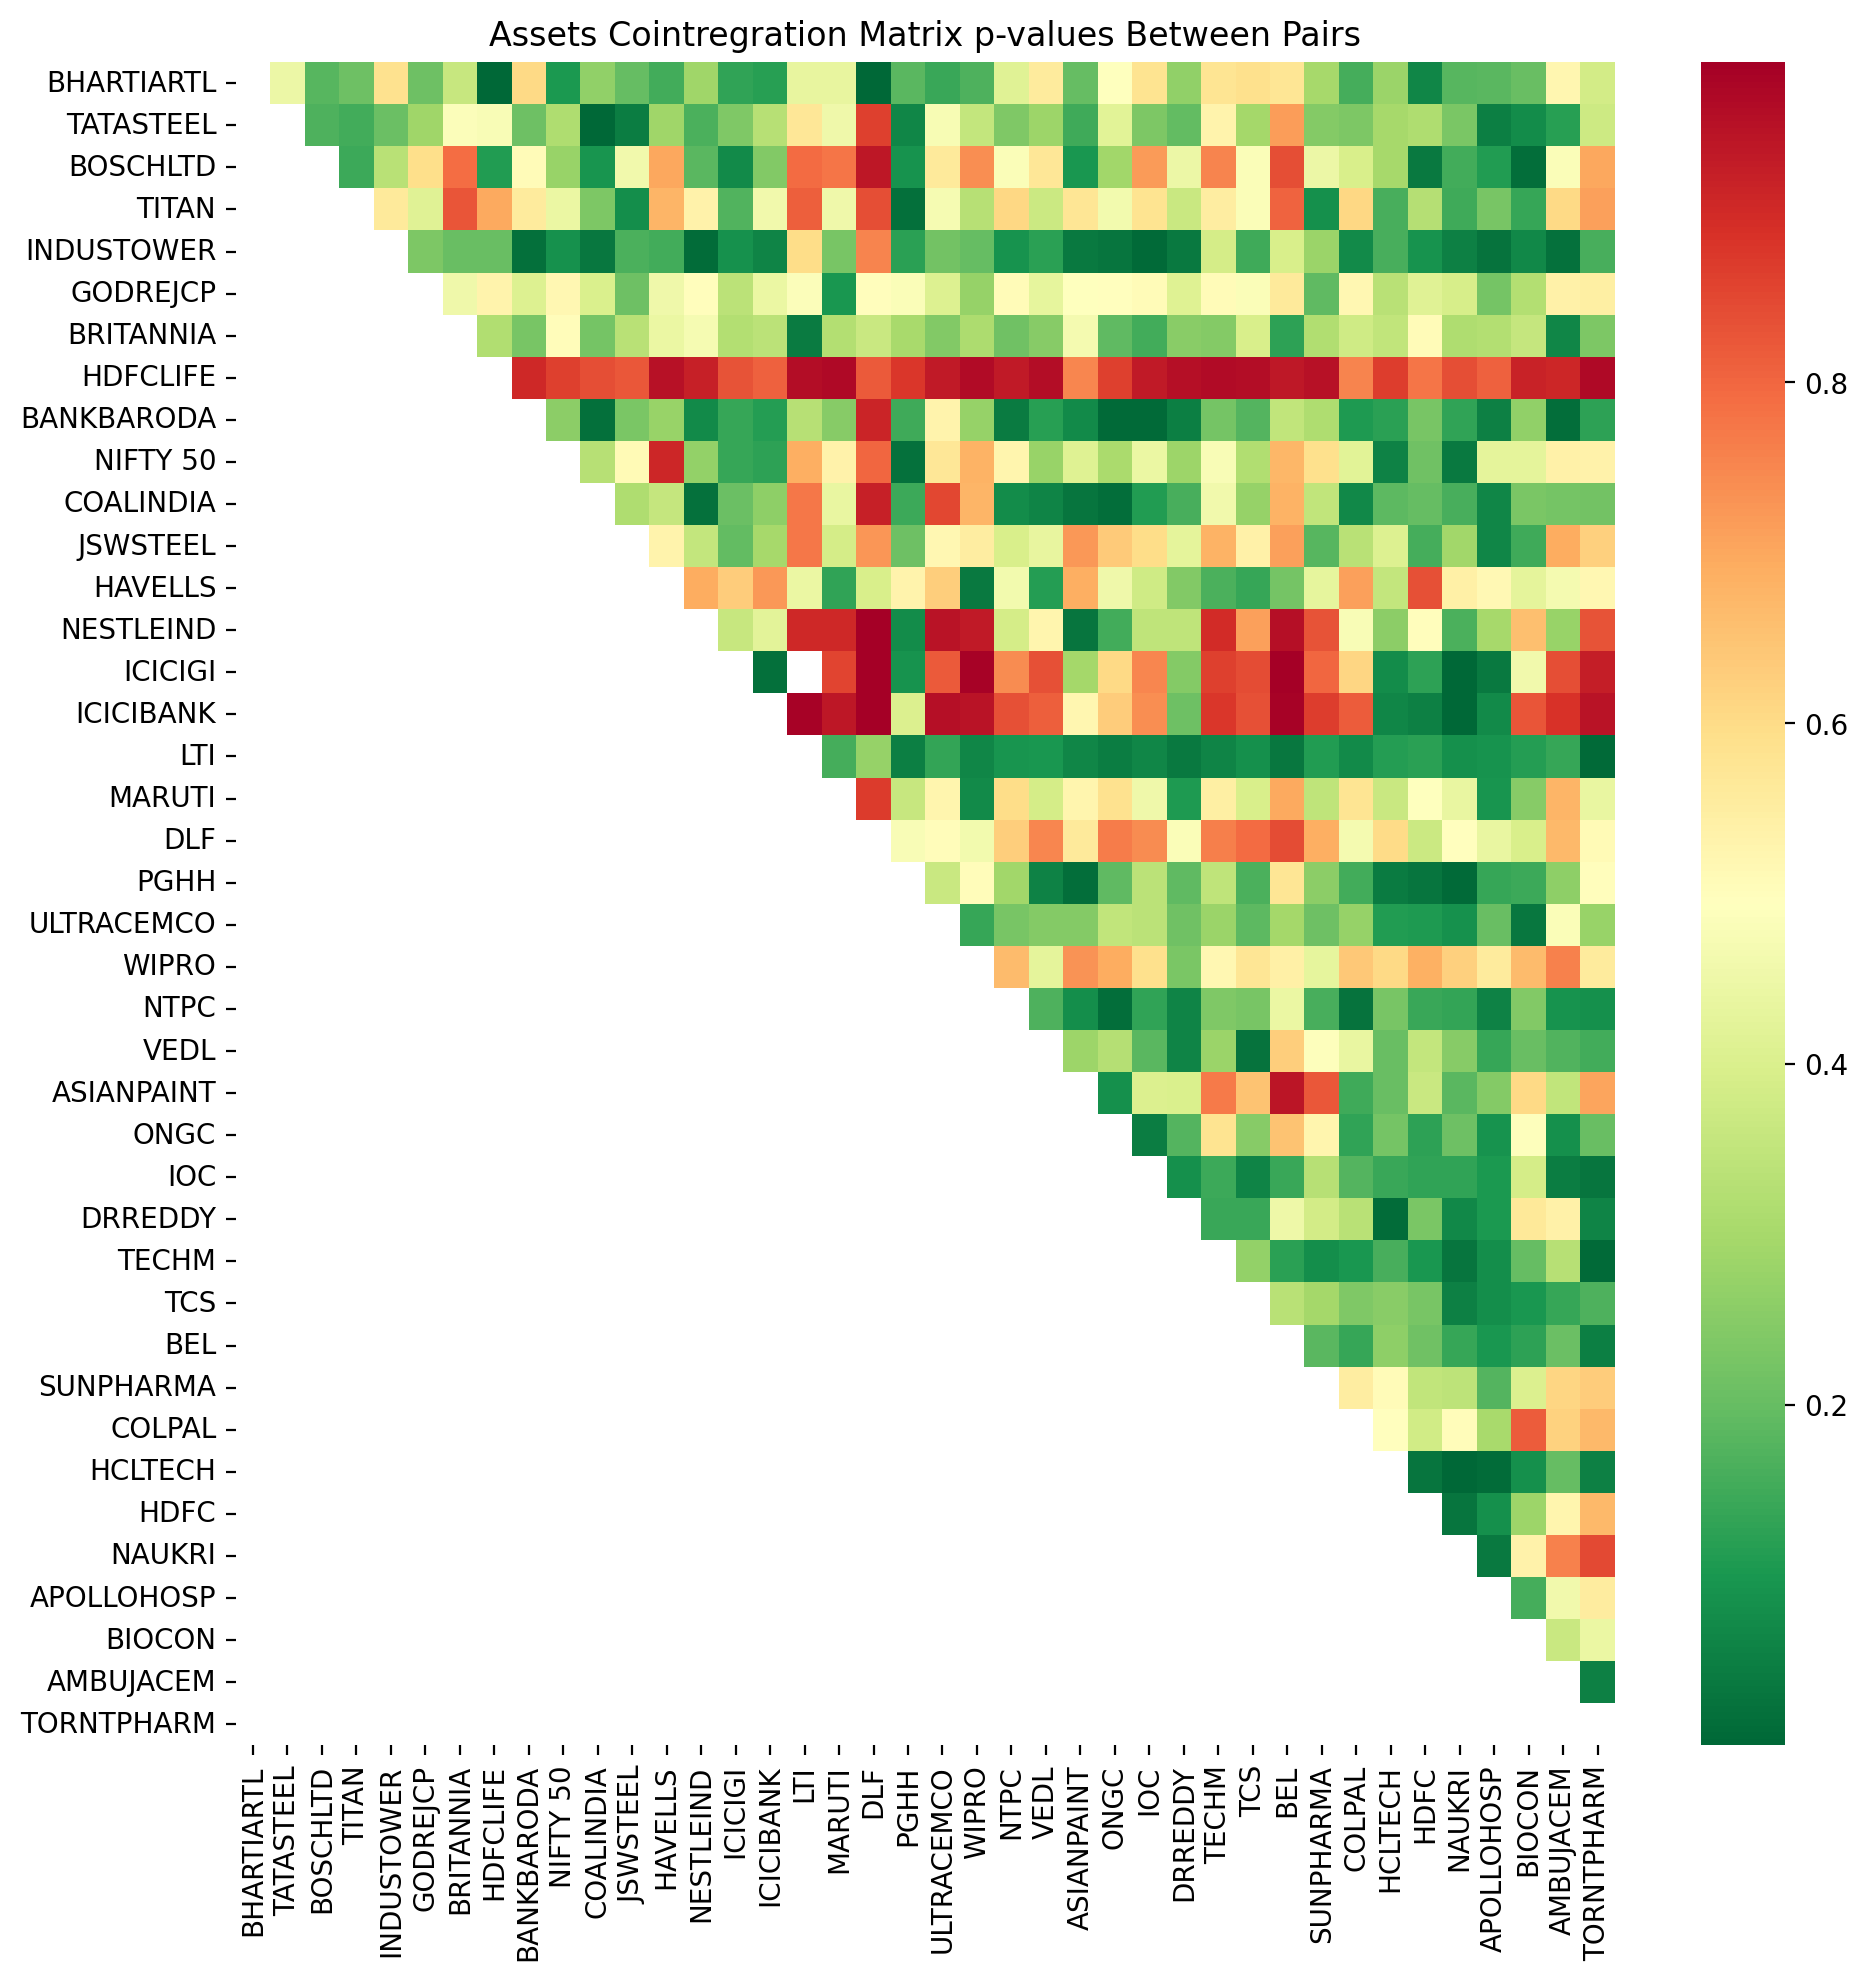

In [36]:
# calculate p-values and plot as a heatmap
# pvalues, pairs = find_cointegrated_pairs_(df)
#print(pairs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues[:40,:40], xticklabels = df.columns[:40],
                yticklabels = df.columns[:40], cmap = 'RdYlGn_r', annot = False,
                mask = (pvalues[:40,:40] >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
# plt.savefig("cointegrated_pairs.png")

We have further defined a function to calculate p-values of the cointegration test for each pair, to generate a heatmap. If the p-value is less than 0.05, the null hypothesis can be rejected and the cointegration between the two time series with distinct symbols. 

We can see in the below heatmap that there are many pairs with a p-value of less than 0.05. This means that for these pairs we can reject the null hypothesis and they can be cointegrated.

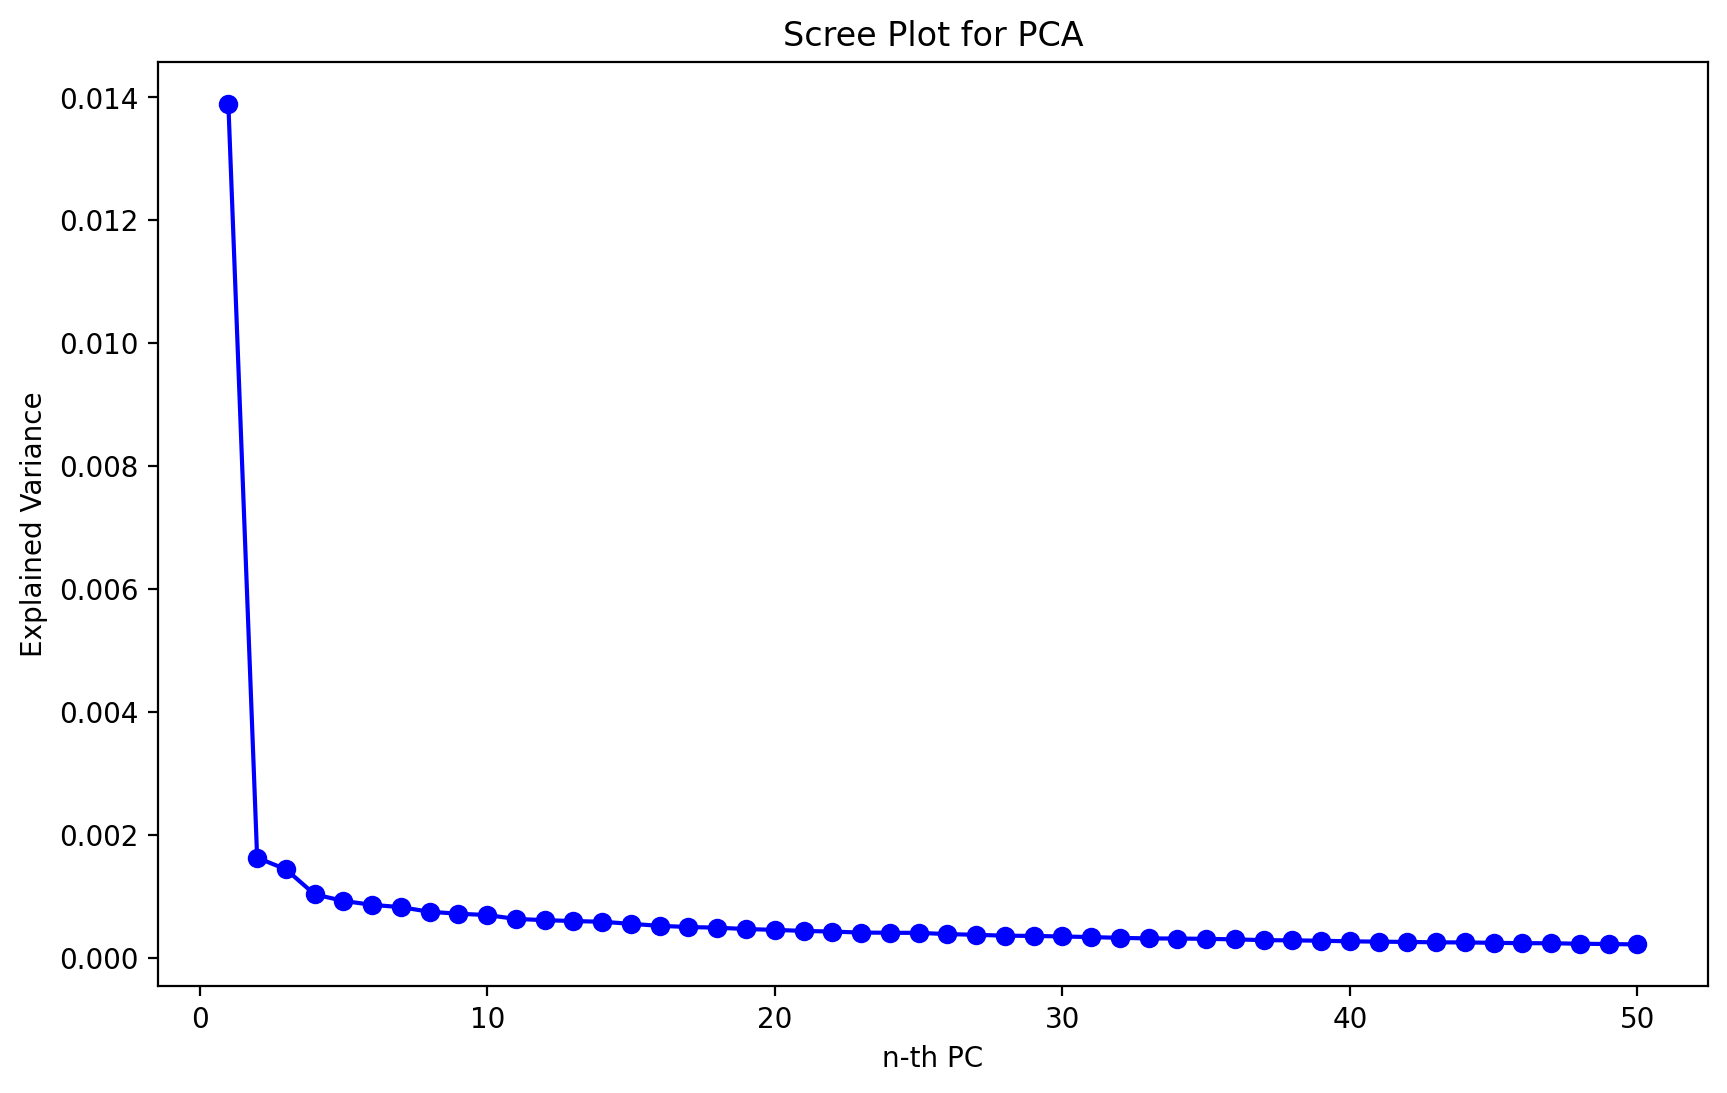

In [23]:
data = df
df.isna().any(axis=1).sum()
prices = data
returns = prices.pct_change().dropna()
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

# A "scree" plot.

plt.figure(figsize=(10,6))
plt.plot(range(1,51),pca.explained_variance_,'b-o')
plt.ylabel("Explained Variance")
plt.xlabel("n-th PC")
plt.title("Scree Plot for PCA")
plt.savefig("variance_pca.png")

DBSCAN(eps=3, min_samples=3)

Clusters discovered: 2


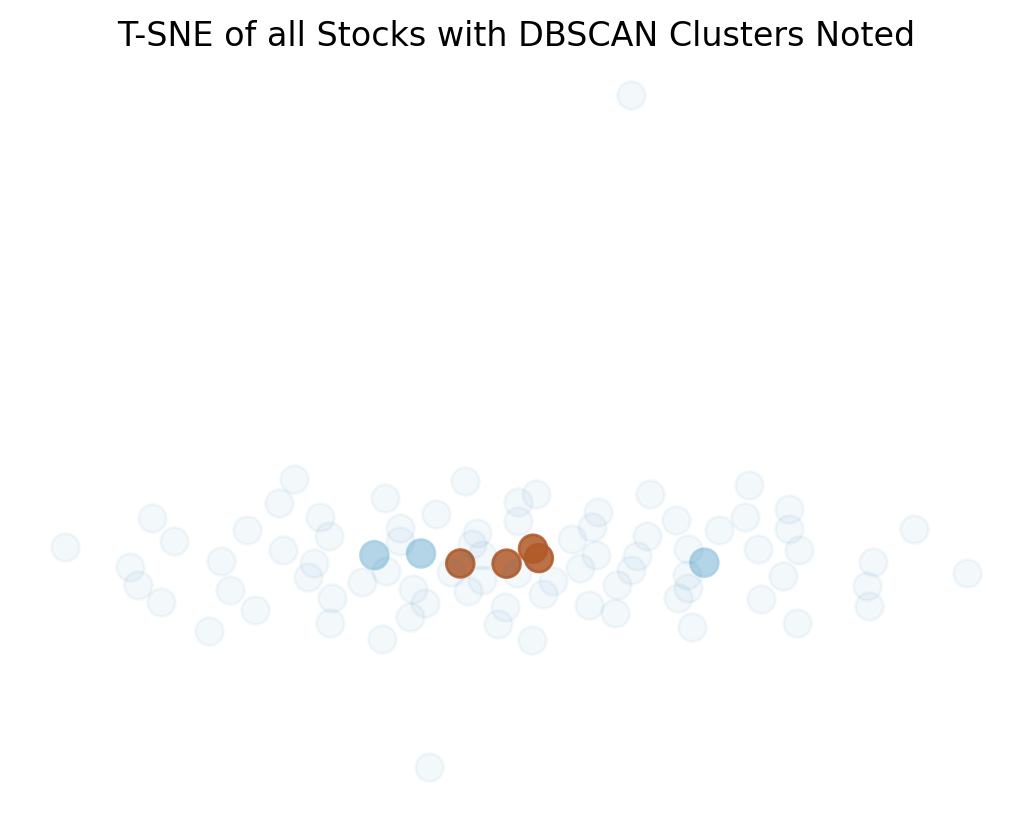

In [24]:
X = pca.components_.T
X = preprocessing.StandardScaler().fit_transform(X)

clf = DBSCAN(eps=3, min_samples=3)
#clf = KMeans()
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
# print("Clusters formed: %d" % len(ticker_count_reduced))
# print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())
# print(ticker_count_reduced)

X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
#plt.savefig("tsne.png")
warnings.simplefilter('ignore')
plt.savefig("tsne.png")

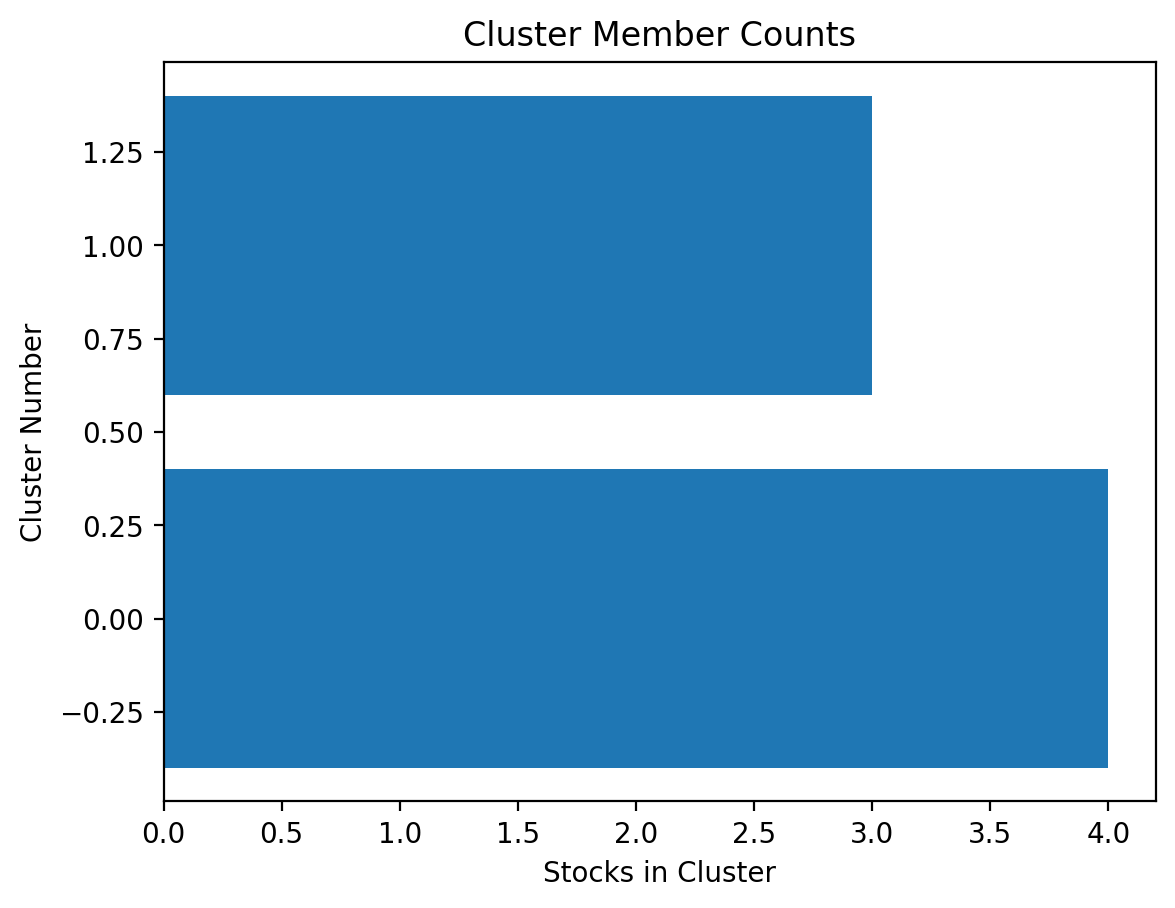

In [25]:
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');
plt.savefig("cluster_member_counts.png")
#print(clustered_series)

<Figure size 200x200 with 0 Axes>

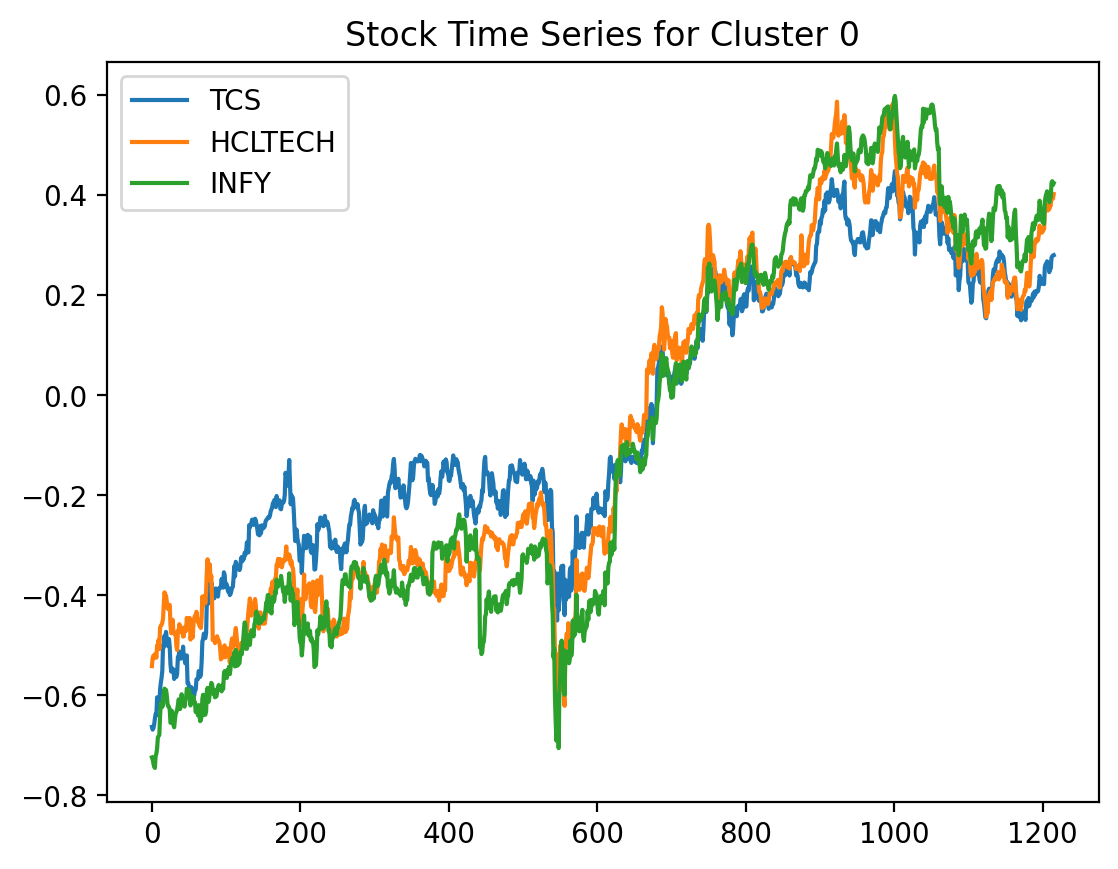

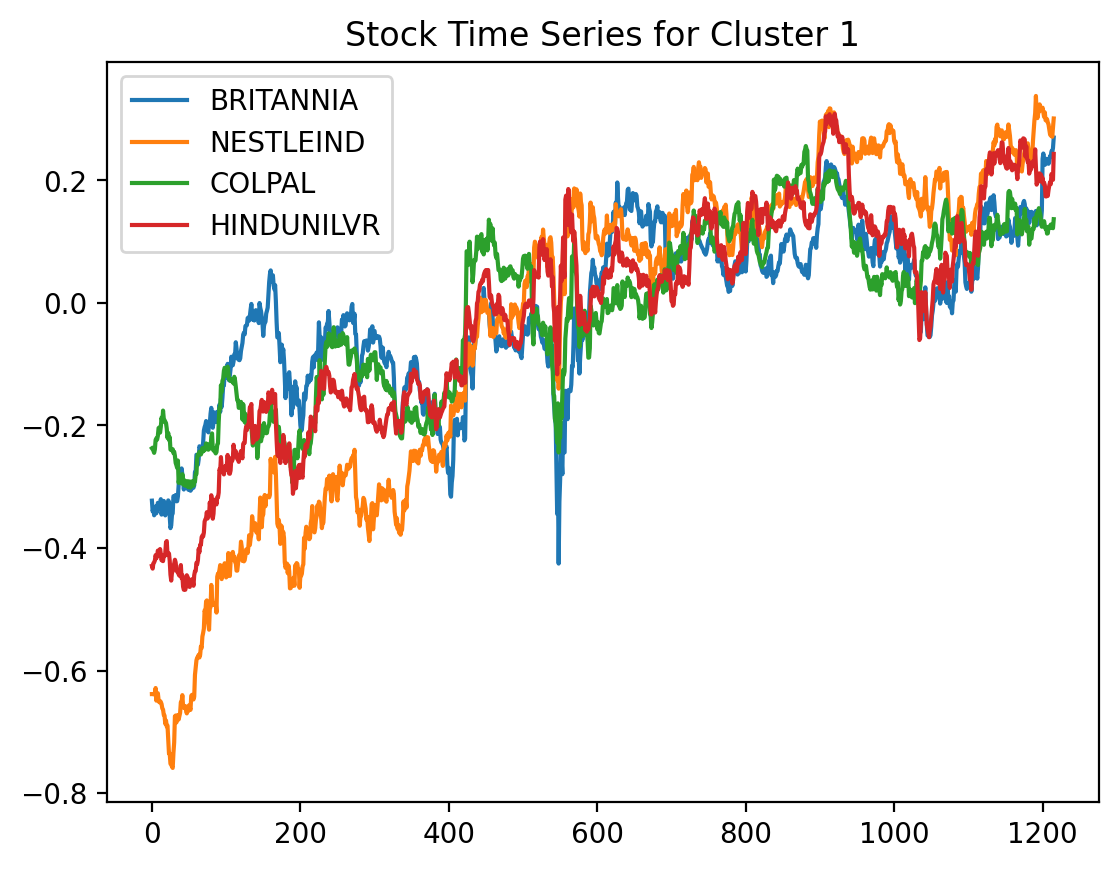

In [31]:
# get the number of stocks in each cluster
plt.figure(figsize=(2,2))
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(prices[tickers].mean())
    data = np.log(prices[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
# plt.savefig("stock_time_series_cluster.png")

## Baseline Model

## References

We have used the following resources as reference for our project:

- http://stat.wharton.upenn.edu/~steele/Courses/434/434Context/PairsTrading/PairsTradingGGR.pdf

- https://hudsonthames.org/employing-machine-learning-for-trading-pairs-selection/

- https://cs230.stanford.edu/projects_fall_2018/reports/12446738.pdf